In [1]:
library(fixest)
library(dplyr)
library(readr)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
base = read_csv('base_tpv_master.csv')

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 16078711 Columns: 26
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): document, tpv_stone, share_tpv_debit, share_tpv_chip_present, sha...
dbl  (15): tpv_total, share_tpv_credit, average_ticket_size, month, year, to...
date  (1): reference_month

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
base$uf = substr(base$municipio,1,2)

In [4]:
m1 = feols(log_total_tpv_credit ~ log_total_tpv_credit_lag + log_total_tpv_credit_mun + media_cnpjs_por_socio + qtd_socios_no_mes | municipio + grupo_cnae_fiscal_principal + reference_month, base)

NOTES: 3,992,625 observations removed because of NA and infinite values (LHS: 1,749,506, RHS: 3,329,248, Fixed-effects: 174).
       3/0/0 fixed-effect singletons were removed (3 observations).



In [5]:
summary(m1)

OLS estimation, Dep. Var.: log_total_tpv_credit
Observations: 12,086,083
Fixed-effects: municipio: 5,544,  grupo_cnae_fiscal_principal: 79,
 reference_month: 12
Standard-errors: IID 
                         Estimate Std. Error  t value  Pr(>|t|)    
log_total_tpv_credit_lag 0.829971   0.000160 5176.146 < 2.2e-16 ***
log_total_tpv_credit_mun 0.398176   0.002987  133.288 < 2.2e-16 ***
media_cnpjs_por_socio    0.013572   0.000093  145.236 < 2.2e-16 ***
qtd_socios_no_mes        0.052254   0.000341  153.326 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.943591     Adj. R2: 0.734685
                 Within R2: 0.70379 

In [6]:
base$yhat = predict(m1, newdata = base)         

In [7]:
base$resid = base$log_total_tpv_credit - base$yhat

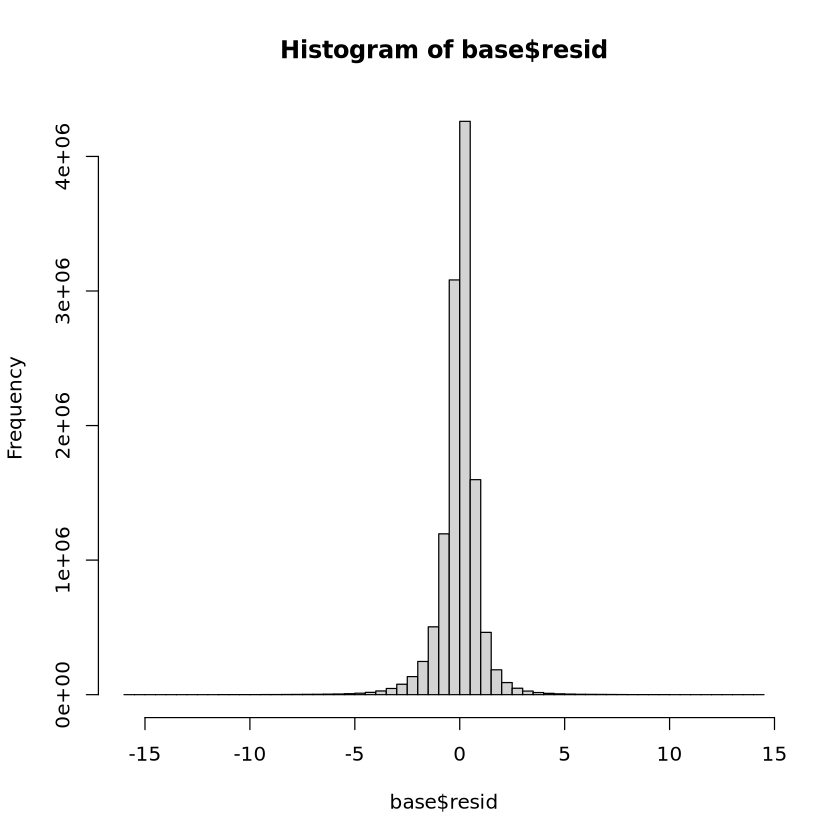

In [9]:
hist(base$resid,breaks=100)

In [10]:
resid_median = median(base$resid,na.rm=T)

In [11]:
base = base %>% mutate(resid_above_median = ifelse(resid >= resid_median,1,0))

In [12]:
base$resid_above_median = base$resid_above_median %>% replace_na(0)

In [13]:
document_agg = base %>%   
               group_by(document) %>% summarise(qtd_above_median = sum(resid_above_median))

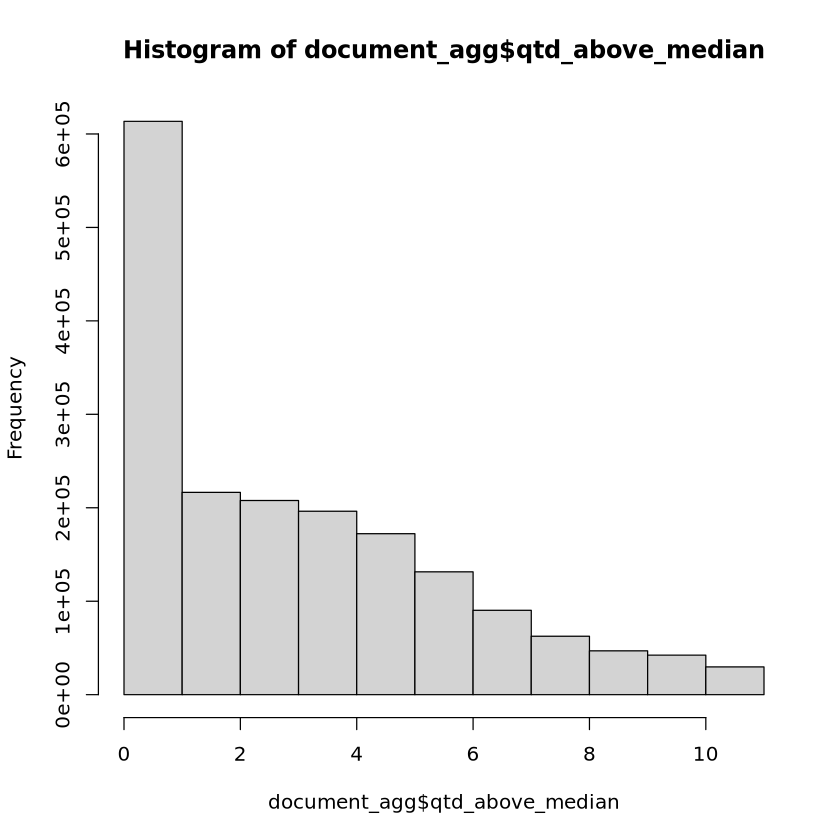

In [14]:
hist(document_agg$qtd_above_median,breaks=10)

In [15]:
quantile(document_agg$qtd_above_median)

0%  25%  50%  75% 100% 
   0    1    3    5   11

In [16]:
document_winners = document_agg %>% filter(qtd_above_median %in% c(11)) %>% pull(document)

In [17]:
base_winners = base %>% filter(document %in% document_winners)

In [18]:
write_csv(base_winners,'document_winners.csv')

In [25]:
doc_ex = base_winners %>% filter(document == document_winners[10])

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


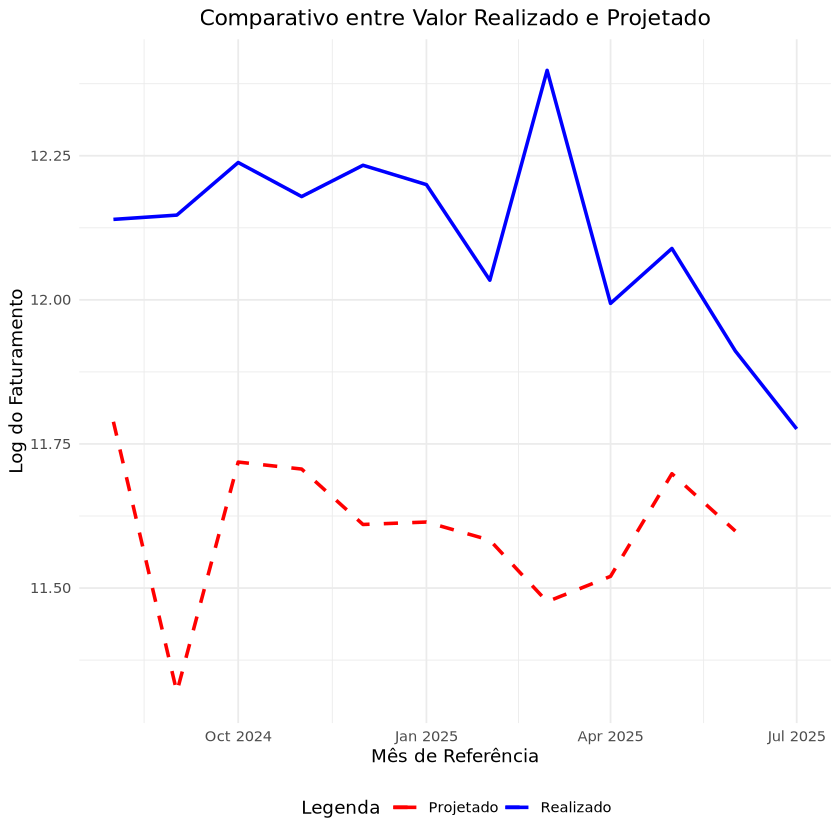

In [29]:
library(ggplot2)

# Supondo que seu dataframe se chama doc_ex
ggplot(doc_ex, aes(x = reference_month)) +
  geom_line(aes(y = log_total_tpv_credit, color = "Realizado"), size = 1) +
  geom_line(aes(y = yhat, color = "Projetado"), linetype = "dashed", size = 1) +
  scale_color_manual(
    values = c("Realizado" = "blue", "Projetado" = "red"),
    name = "Legenda"
  ) +
  labs(
    x = "Mês de Referência",
    y = "Log do Faturamento",
    title = "Comparativo entre Valor Realizado e Projetado"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5),
    legend.position = "bottom"
  )
